<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/Copy_of_LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import os
import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import numpy as np
import altair as alt 
import tensorflow as tf 
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [8]:
#Import Data 
stockDf = pd.read_csv('AAPL.csv',delimiter=',') 
#start = dt.datetime(2018, 1, 1)
#end = dt.datetime(2022, 4, 27)
#stockDf = web.DataReader(name='AAPL', data_source='yahoo', start=start,end= end)
stockDf['openChange'] = stockDf.Open.pct_change()
stockDf['closeChange'] = stockDf.Close.pct_change()
stockDf['weekday_num'] = pd.DatetimeIndex(stockDf['Date']).weekday
stockDf['month'] = pd.DatetimeIndex(stockDf['Date']).month
stockDf['day'] = pd.DatetimeIndex(stockDf['Date']).day
stockDf['year'] = pd.DatetimeIndex(stockDf['Date']).year
stockDf['display'] = stockDf["month"].map(str)+ "-" + stockDf["year"].map(str)

# Select features (columns) to be involved intro training and predictions
cols = list(stockDf)[1:2]
#cols.pop(1) #Delete middle column

# Extract dates (will be used in visualization)
datelist_train = list(stockDf['Date']) 
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(stockDf.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (254, 14)
All timestamps == 254
Featured selected: ['Open']


In [98]:
(alt.Chart(stockDf).mark_line().encode(x='Date', y='Open').properties(height=400, width=500))

alt.Chart(...)

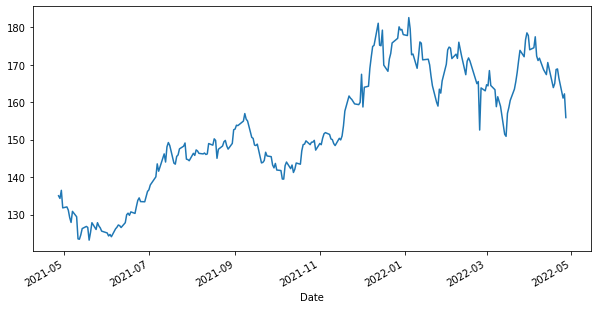

In [99]:
stockDf.Date = pd.to_datetime(stockDf.Date, format = '%Y/%m/%d')
plot_Stock = stockDf.set_index('Date') 
plot_Stock['Open'].plot(figsize=(10,5))

In [ ]:
closedChart = (alt.Chart(stockDf).mark_line().encode(x='Date', y='closeChange', color=alt.value('black')).properties(height=400, width=2000))
openChart = (alt.Chart(stockDf).mark_line().encode(x='Date', y='openChange', color=alt.value('green')).properties(height=400, width=2000))
closedChart+openChart

In [ ]:
open = (alt.
         Chart(stockDf).
         mark_line().
         encode(x=alt.X('display', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=400, width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.year==2018).
         mark_line().
         encode(x=alt.X('display', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=200, width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.year==2018).
         mark_line().
         encode(x=alt.X('week(Date):T', sort=['year', 'month']), y='max(Close)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).
         mark_line().
         encode(x=alt.X('month(Date):T'), y='max(closeChange)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.month==3).
         mark_line().
         encode(x=alt.X('day', sort=['year', 'month']), y='max(Volume)', color='year').
         properties(height=200  , width=500))
open

In [ ]:
from altair import datum
open = (alt.
         Chart(stockDf).transform_filter(datum.month==3).
         mark_line().
         encode(x=alt.X('day', sort=['year', 'month']), y='max(closeChange)', color='year').
         properties(height=200  , width=500))
open

In [117]:
#Get Desired columns to train
print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors) 
fromRecord = 50
toRecord = 100
newDf = stockDf.loc[fromRecord:toRecord] 
myDs = newDf.to_numpy() 
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf[1:5]


Featured selected: ['Open']
Shape of training set == (51, 1).


,Open
51,142.750000
52,146.210007
53,144.029999
54,148.100006


In [118]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]


In [119]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

#Reshape data to normalize it [samples, time steps, features]
print("take 1")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))
print("take 2")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))

take 1
X_Train[0] (Samples): 29
X_Train[1] (Features): 5
take 2
X_Train[0] (Samples): 29
X_Train[1] (Features): 1


In [120]:
#Parameters
verboseAmt = 1
epochCnt = 100
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = True

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
6/6 [==============================] - 6s 218ms/step - loss: 0.1259 - val_loss: 0.3103
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1114 - val_loss: 0.2858
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0961 - val_loss: 0.2572
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0788 - val_loss: 0.2225
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0594 - val_loss: 0.1794
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0410 - val_loss: 0.1269
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0190 - val_loss: 0.0724
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0130 - val_loss: 0.0386
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0164 - val_loss: 0.0348
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0173 - val_loss: 0.0491
Epoch 11/100
6/6 [===

In [129]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

IndexError: ignored

In [126]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('X Train Shape' + str(X_train.shape))
print('Y Train Shape' + str(Y_train.shape))
print('X Test Shape' + str(X_test.shape))
print('Y Test Shape' + str(Y_test.shape))
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 29
X_test: 29
Y_train: 29
Y_test: 29
X Train Shape(29, 1, 5)
Y Train Shape(29, 1)
X Test Shape(29, 1, 5)
Y Test Shape(29, 1)
train_predict: 29
Y_trained_predict: 29
test_predict: 29
Y_test_predict: 29
Shape of Y_train:29
Shape of Y_train:29
Shape of Y_train:29
Shape of Y_train:29


In [125]:
#inverse the inverse
Y_trained_predict = scaler.inverse_transform(train_predict)
Y_test_predict = scaler.inverse_transform(test_predict)

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]
Y_test = Y_test.reshape(s2,s1)
s1 = Y_train.shape[0]
s2 = Y_train.shape[1]
Y_train = Y_train.reshape(s2,s1)

In [127]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
0.47549131992115856 

Test RMSE is: 
0.8811825559177325


In [109]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)
result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,148.100008,147.970566
1,149.240010,149.114365
2,148.460006,148.442184
3,143.750005,144.192215
4,143.460004,143.807144


Text(0, 0.5, 'Value of Stock')

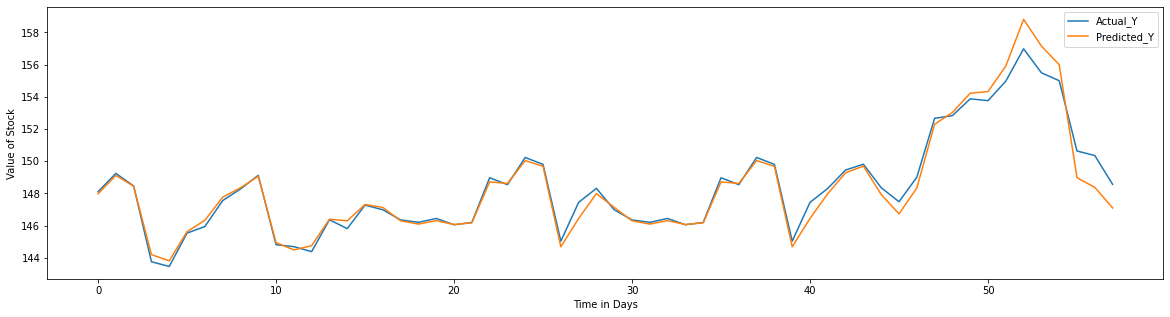

In [110]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')